In [158]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from tqdm import trange
from utils import evaluate_clustering, get_clusters, plot_training_history, plot_3d_clustering_comparison

# Contrastive Multi-View Representation Learning on Graphs
From the paper [Contrastive Multi-View Representation Learning on Graphs](https://arxiv.org/abs/2006.05582)

## Loading the data
We use the Cora dataset.

In [159]:
def compute_diffusion_matrix(adj: np.ndarray, alpha: float = 0.2) -> np.ndarray:
  adj = adj + np.eye(adj.shape[0])
  deg_sqrt_inv = np.diag(1.0 / np.sqrt(np.sum(adj, axis=1)))
  return np.dot(np.linalg.inv(np.eye(adj.shape[0]) - alpha * np.dot(deg_sqrt_inv, adj).T), (1 - alpha) * deg_sqrt_inv)

In [160]:
dataset = Planetoid(root='../data/Planetoid', name='Cora')
data = dataset[0]
diff = torch.from_numpy(
  compute_diffusion_matrix(
    to_dense_adj(data.edge_index)[0].numpy(), .1
  )
)
diff[diff < 1e-6] = 0  # remove small values for computational time (sparse matrix, from 6M to 600k edges)
diff = dense_to_sparse(diff)
data.diff_edge_index = diff[0]
data.diff_edge_weight = diff[1].float()
data.train_mask = data.test_mask = data.val_mask = None
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], diff_edge_index=[2, 589805], diff_edge_weight=[589805])

## Multi-View Graph Representation Learning (MVGRL) model

In [161]:
class GCN(nn.Module):
  """Graph Convolutional Network (GCN) module that returns the embeddings of the nodes at each GCN layer
  
  :param in_channels: Number of input features
  :type in_channels: int
  :param out_channels: Number of output features
  :type out_channels: int
  """
  def __init__(self, in_channels: int, out_channels: int):
    super(GCN, self).__init__()
    self.conv1: GCNConv = GCNConv(in_channels, out_channels)
    self.conv2: GCNConv = GCNConv(out_channels, out_channels)
    self.prelu: nn.PReLU = nn.PReLU()

  def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> tuple[torch.tensor, torch.tensor]:
    """Forward pass
    
    :param x: Input features
    :type x: torch.tensor
    :param edge_index: Edge index tensor
    :type edge_index: torch.tensor
    :param edge_weight: Edge weight tensor (if any)
    :type edge_weight: torch.tensor
    :return: Embeddings of the nodes at each GCN layer
    :rtype: tuple[torch.tensor, torch.tensor]
    """
    h1 = self.conv1(x, edge_index, edge_weight)
    h2 = self.conv2(self.prelu(h1), edge_index, edge_weight)
    return h1, h2

In [162]:
class Readout(nn.Module):
  """Readout function for a two-layer GCN model
  
  :param in_channels: Number of input features in each hidden layer
  :type in_channels: int
  """
  def __init__(self, in_channels: int):
    super(Readout, self).__init__()
    self.linear: nn.Linear = nn.Linear(in_channels * 2, in_channels, bias=False)
    self.prelu: nn.PReLU = nn.PReLU()

  def forward(self, h1: torch.tensor, h2: torch.tensor) -> torch.tensor:
    """Pooling layer
    
    :param h1: Embeddings of the nodes at the first GCN layer
    :type h1: torch.tensor
    :param h2: Embeddings of the nodes at the second GCN layer
    :type h2: torch.tensor
    :return: Pooled embeddings
    :rtype: torch.tensor
    """
    h = torch.cat([h1.mean(dim=-2), h2.mean(dim=-2)], dim=-1)
    return self.prelu(self.linear(h)) # Eq. (4)

In [163]:
class Discriminator(nn.Module):
  """Discriminator module
  
  :param in_channels: Number of features in the hidden GCN layers
  :type in_channels: int
  """
  def __init__(self, in_channels: int):
    super(Discriminator, self).__init__()
    self.bilinear: nn.Bilinear = nn.Bilinear(in_channels, in_channels, 1)

  def forward(self, h1: torch.tensor, h2: torch.tensor, h3: torch.tensor, h4: torch.tensor, r1: torch.tensor, r2: torch.tensor) -> torch.tensor:
    """Forward pass
    
    :param h1: Embeddings of the nodes of the original view after the GCN_real layers
    :type h1: torch.tensor
    :param h2: Embeddings of the nodes of the diffused view after the GCN_diff layers
    :type h2: torch.tensor
    :param h3: Embeddings of the shuffled (corrupted) nodes of the original view after the GCN_real layers
    :type h3: torch.tensor
    :param h4: Embeddings of the shuffled (corrupted) nodes of the diffused view after the GCN_diff layers
    :type h4: torch.tensor
    :param r1: Output of the readout layer for the original view
    :type r1: torch.tensor
    :param r2: Output of the readout layer for the diffused view
    :type r2: torch.tensor
    :return: Discriminator output of shape for each gcn layer: positive (real) and negative (corrupted) pairs
    :rtype: torch.tensor
    """
    r1 = r1.expand_as(h1)
    r2 = r2.expand_as(h2)
    return torch.cat([
      self.bilinear(h2, r1).squeeze(),  # diffused nodes vs real pooled, should be positive
      self.bilinear(h1, r2).squeeze(),  # real nodes vs diffused pooled, should be positive
      self.bilinear(h4, r1).squeeze(),  # corrupted diffused nodes vs real pooled, should be negative
      self.bilinear(h3, r2).squeeze() # corrupted real nodes vs diffused pooled, should be negative 
    ], dim=-1)

In [171]:
class MVGRLModel(nn.Module):
  """Multi-View Graph Representation Learning (MVGRL) model
  
  :param in_channels: Number of input features
  :type in_channels: int
  :param latent_dim: Dimension of the latent space
  :type latent_dim: int
  """
  def __init__(self, in_channels: int, latent_dim: int):
    super(MVGRLModel, self).__init__()
    self.gcn_real: GCN = GCN(in_channels, latent_dim)
    self.gcn_diff: GCN = GCN(in_channels, latent_dim)
    self.readout: Readout = Readout(latent_dim)
    self.discriminator: Discriminator = Discriminator(latent_dim)

  def forward(self, x: torch.tensor, edge_index: torch.tensor, diff_edge_index: torch.tensor, diff_edge_weight: torch.tensor) -> tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
    """Forward pass
    
    :param x: Input features
    :type x: torch.tensor
    :param edge_index: Edge index tensor
    :type edge_index: torch.tensor
    :param diff_edge_index: Diffused edge index tensor
    :type diff_edge_index: torch.tensor
    :param diff_edge_weight: Diffused edge weight tensor
    :type diff_edge_weight: torch.tensor
    :return: Discriminator output, readout output of the original view, readout output of the diffused view, embeddings of the nodes of the original view, embeddings of the nodes of the diffused view
    :rtype: tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor]
    """
    h1_real, h2_real = self.gcn_real(x, edge_index)
    h1_diff, h2_diff = self.gcn_diff(x, diff_edge_index, diff_edge_weight)
    corrupted_idx = torch.randperm(x.size(0))
    h3_real, h4_real = self.gcn_real(x[corrupted_idx], edge_index)
    h3_diff, h4_diff = self.gcn_diff(x[corrupted_idx], diff_edge_index, diff_edge_weight)
    r1 = self.readout(h1_real, h2_real)
    r2 = self.readout(h1_diff, h2_diff)
    return self.discriminator(h2_real, h2_diff, h4_real, h4_diff, r1, r2), r1, r2, h1_real, h1_diff


  def embed(self, x: torch.tensor, edge_index: torch.tensor, diff_edge_index: torch.tensor, diff_edge_weight: torch.tensor) -> torch.tensor:
    """Embedding function
    
    :param x: Input features
    :type x: torch.tensor
    :param edge_index: Edge index tensor
    :type edge_index: torch.tensor
    :param diff_edge_index: Diffused edge index tensor
    :type diff_edge_index: torch.tensor
    :param diff_edge_weight: Diffused edge weight tensor
    :type diff_edge_weight: torch.tensor
    :return: Node embeddings
    :rtype: torch.tensor
    """
    _, h_real = self.gcn_real(x, edge_index)
    _, h_diff = self.gcn_diff(x, diff_edge_index, diff_edge_weight)
    return h_real + h_diff

## Instantiating and training the models
The DGAE model is instantiated and trained with the loss function specified in the paper, which uses the reconstruction loss of the adjacency matrix and of the feature matrix.

In [172]:
def train_model(model: nn.Module, data: Data, optimizer: optim.Optimizer, num_epochs: int = 200, tqdm_desc: str = "Epochs", n_clusters: int = 7, n_tries: int = 5) -> np.ndarray:
  metrics = np.zeros((num_epochs, 5))
  criterion = nn.BCEWithLogitsLoss()
  true_labels = torch.ones(data.x.size(0) * 2, dtype=torch.float)
  corrupted_labels = torch.zeros(data.x.size(0) * 2, dtype=torch.float)
  labels = torch.cat([true_labels, corrupted_labels], dim=-1)
  for epoch in (pbar := trange(num_epochs, desc=tqdm_desc)):
    optimizer.zero_grad()
    discriminator_output, _, _, _, _ = model(data.x, data.edge_index, data.diff_edge_index, data.diff_edge_weight)
    loss = criterion(discriminator_output, labels)
    loss.backward()
    optimizer.step()
    z_np = model.embed(data.x, data.edge_index, data.diff_edge_index, data.diff_edge_weight).detach().numpy()
    clusters = [get_clusters(z_np, n_clusters) for _ in range(n_tries)] # the score can depend on the initial cluster assignment, so we try multiple times
    accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, max(clusters, key=lambda c: evaluate_clustering(z_np, data.y, c)[0]))
    metrics[epoch] = np.array([loss.item(), accuracy, nmi, ari, silouhette])
    pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})
  return metrics

In [178]:
latent_dim, num_epochs, lr, n_clusters = 256, 100, .001, len(np.unique(data.y.numpy()))

mvgrl = MVGRLModel(data.num_features, latent_dim)
optimizer = optim.Adam(mvgrl.parameters(), lr=lr)

In [179]:
training = train_model(mvgrl, data, optimizer, num_epochs, "DGAE", n_clusters)
history_labels = ['Loss', 'Accuracy', 'NMI Score', 'ARI Score', 'Silouhette Score']

DGAE: 100%|██████████| 100/100 [11:52<00:00,  7.12s/it, Loss=0.333, Accuracy=0.568, NMI=0.316, ARI=0.221, Silouhette=0.0711] 


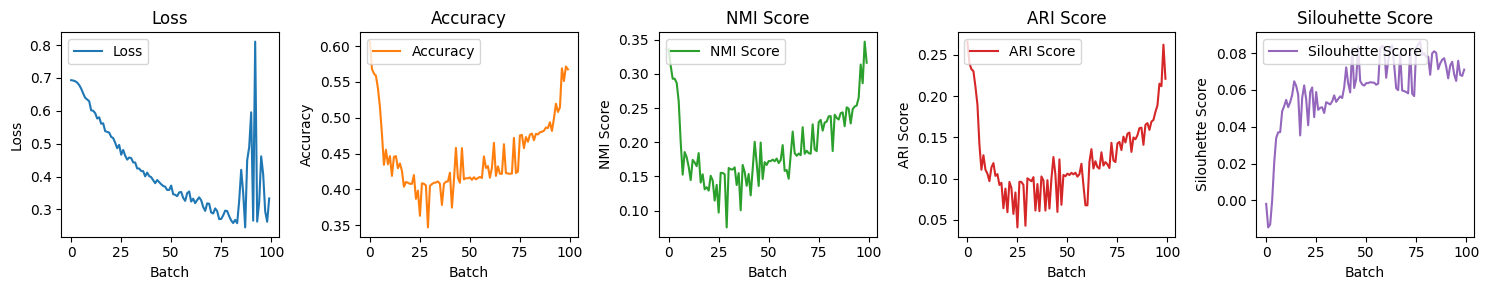

In [180]:
plot_training_history(history_labels, training, "MVGRL Training")

In [181]:
z_np = mvgrl.embed(data.x, data.edge_index, data.diff_edge_index, data.diff_edge_weight).detach().numpy()

n_tries = 5
clusters = [get_clusters(z_np, n_clusters) for _ in range(n_tries)]
best_clusters = max(clusters, key=lambda c: evaluate_clustering(z_np, data.y, c)[0])

accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, best_clusters)
print(f"Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, ARI: {ari:.4f}, Silouhette: {silouhette:.4f}")

Accuracy: 0.5595, NMI: 0.3282, ARI: 0.2600, Silouhette: 0.0742


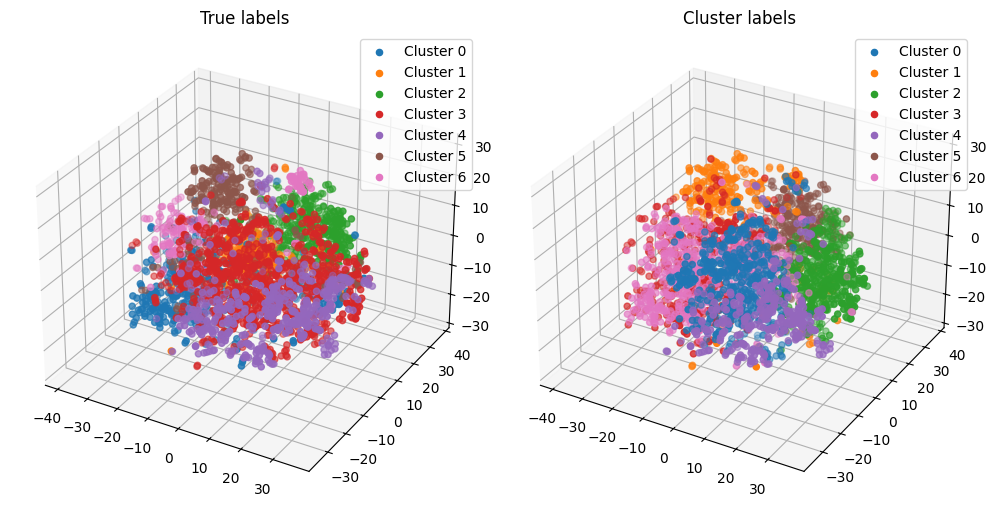

In [182]:
plot_3d_clustering_comparison(z_np, data.y, best_clusters, n_clusters)